In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import numpy as np
import jax.numpy as jnp

import seaborn as sns
sns.set_context('paper', font_scale = 1.5)
sns.color_palette('colorblind')

import h5py

import corner

#for approximating GW likelihood

from scipy.stats import gaussian_kde
from jaxinterp2d import interp2d

#for numpyro sampling

from jax import random
import numpyro
from numpyro.infer import MCMC, NUTS

#for calculating rates from GC models
import GC_rates

In [2]:
#read in GC model data
GC_data = GC_rates.read_data()

#read in GW population posterior
# TO DO: try to use the GW likelihood by calculating GW_prior from prior draws and dividing, or overplot priors on corner plot.

with h5py.File('GW_dynrate_z0_z1.h5', 'r') as inp:
    GW_R0_post = np.array(inp['dyn_rate_z0'])
    GW_R1_post = np.array(inp['dyn_rate_z1'])
    
with h5py.File('GW_dynrate_versus_z.h5', 'r') as inp:
    dyn_rate = np.array(inp['dyn_rate'])
    z_plot = np.array(inp['z'])
    total_rate = np.array(inp['total_rate'])


In [3]:
#define approximate GW likelihood
GW_R0R1_post = np.row_stack((np.log(GW_R0_post), np.log(GW_R1_post)))
GW_R0R1_joint_kde = gaussian_kde(GW_R0R1_post)

logR0_grid = jnp.linspace(jnp.log(0.1), jnp.log(1000), 1000)
logR1_grid = jnp.linspace(jnp.log(0.1), jnp.log(1000), 1000)

R0p, R1p = jnp.meshgrid(logR0_grid, logR1_grid, indexing = "ij")

GW_R0R1_post_kde_grid = GW_R0R1_joint_kde.evaluate(np.row_stack((R0p.flatten(), R1p.flatten())))

def GW_logpost(R0,R1):
    return interp2d(jnp.log(R0), jnp.log(R1), logR0_grid, logR1_grid, jnp.log(GW_R0R1_post_kde_grid.reshape(1000,1000)))

In [4]:
sigma_dex = 0.5 #spread in metallicity distribution at each redshift
Zsun = 0.02 #solar metallicity
logMlo = 2 #minimum GC mass is 10^2 Msun
logMhi = 8 #maximum GC mass is 10^8 Msun
average_M_evolved = 3.2e5 #average mass of evolved clusters in Msun, used to convert mass density rho_GC to number density of evolved clusters
rho_GC = 7.3e14 #mass density of evolved clusters in Msun/ Mpc^3

def loglike(z_gc, a, b, mu_rv, sigma_rv, beta, logMstar0, logDelta):
    R0 = GC_rates.merger_rate_at_z_pop_selfconsistentfactors(
        GC_data, 0, z_gc, a, b, sigma_dex, Zsun, mu_rv, sigma_rv, 
        beta, logMstar0, rho_GC, logDelta, logMlo, logMhi, average_M_evolved)
    R1 = GC_rates.merger_rate_at_z_pop_selfconsistentfactors(
        GC_data, 1, z_gc, a, b, sigma_dex, Zsun, mu_rv, sigma_rv, 
        beta, logMstar0, rho_GC, logDelta, logMlo, logMhi, average_M_evolved)
    return GW_logpost(R0, R1)

def prior(z_gc_bounds = [1, 8], a_bounds = [1,5], b_bounds = [1,5], 
          mu_rv_bounds = [0.5, 4], sigma_rv_bounds = [1, 3], 
          beta_bounds = [-4, 4], logMstar0_bounds = [5.5, 6.5],
          logDelta_bounds = [4, 6]):
    
    cluster_params = dict()
    
    cluster_params['z_gc'] = numpyro.sample('z_gc', numpyro.distributions.Uniform(low = z_gc_bounds[0], high = z_gc_bounds[1]))
    cluster_params['a'] = numpyro.sample('a', numpyro.distributions.Uniform(low = a_bounds[0], high = a_bounds[1]))
    cluster_params['b'] = numpyro.sample('b', numpyro.distributions.Uniform(low = b_bounds[0], high = b_bounds[1]))
    cluster_params['mu_rv'] = numpyro.sample('mu_rv', numpyro.distributions.Uniform(low = mu_rv_bounds[0], high = mu_rv_bounds[1]))
    cluster_params['sigma_rv'] = numpyro.sample('sigma_rv', numpyro.distributions.Uniform(low = sigma_rv_bounds[0], high = sigma_rv_bounds[1]))
    cluster_params['beta'] = numpyro.sample('beta', numpyro.distributions.Uniform(low = beta_bounds[0], high = beta_bounds[1]))
    cluster_params['logMstar0'] = numpyro.sample('logMstar0', numpyro.distributions.Uniform(low = logMstar0_bounds[0], high = logMstar0_bounds[1]))
    cluster_params['logDelta'] = numpyro.sample('logDelta', numpyro.distributions.Uniform(low = logDelta_bounds[0], high = logDelta_bounds[1]))
 
    return cluster_params

def posterior(z_gc_bounds = [1, 8], a_bounds = [1,5], b_bounds = [1,5], 
          mu_rv_bounds = [0.5, 4], sigma_rv_bounds = [1, 3], 
          beta_bounds = [-4, 4], logMstar0_bounds = [5.5, 6.5],
          logDelta_bounds = [4, 6]):
    
    ll = loglike(**prior(z_gc_bounds, a_bounds, b_bounds, 
                         mu_rv_bounds, sigma_rv_bounds, beta_bounds,
                        logMstar0_bounds, logDelta_bounds))
    
    numpyro.factor('loglikelihood', ll)

In [9]:
sampler = MCMC(NUTS(posterior), num_warmup=8000, num_samples=8000, progress_bar = True)

sampler.run(random.PRNGKey(0))

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 16000/16000 [05:50<00:00, 45.70it/s, 20 steps of size 1.49e-01. acc. prob=0.83]


In [10]:
samples = sampler.get_samples()
sampler.print_summary()


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          a      3.31      1.07      3.42      1.73      5.00   1091.55      1.00
          b      3.04      1.15      3.07      1.06      4.63   1284.93      1.00
       beta     -1.80      0.40     -1.82     -2.45     -1.21    532.90      1.01
   logDelta      4.62      0.39      4.59      4.02      5.19    950.07      1.00
  logMstar0      6.26      0.13      6.25      6.07      6.46    680.28      1.00
      mu_rv      2.41      1.00      2.51      0.95      4.00   1494.06      1.00
   sigma_rv      2.00      0.58      2.01      1.14      2.94   1334.74      1.00
       z_gc      4.99      1.86      5.14      2.29      7.99   1730.38      1.00

Number of divergences: 6894


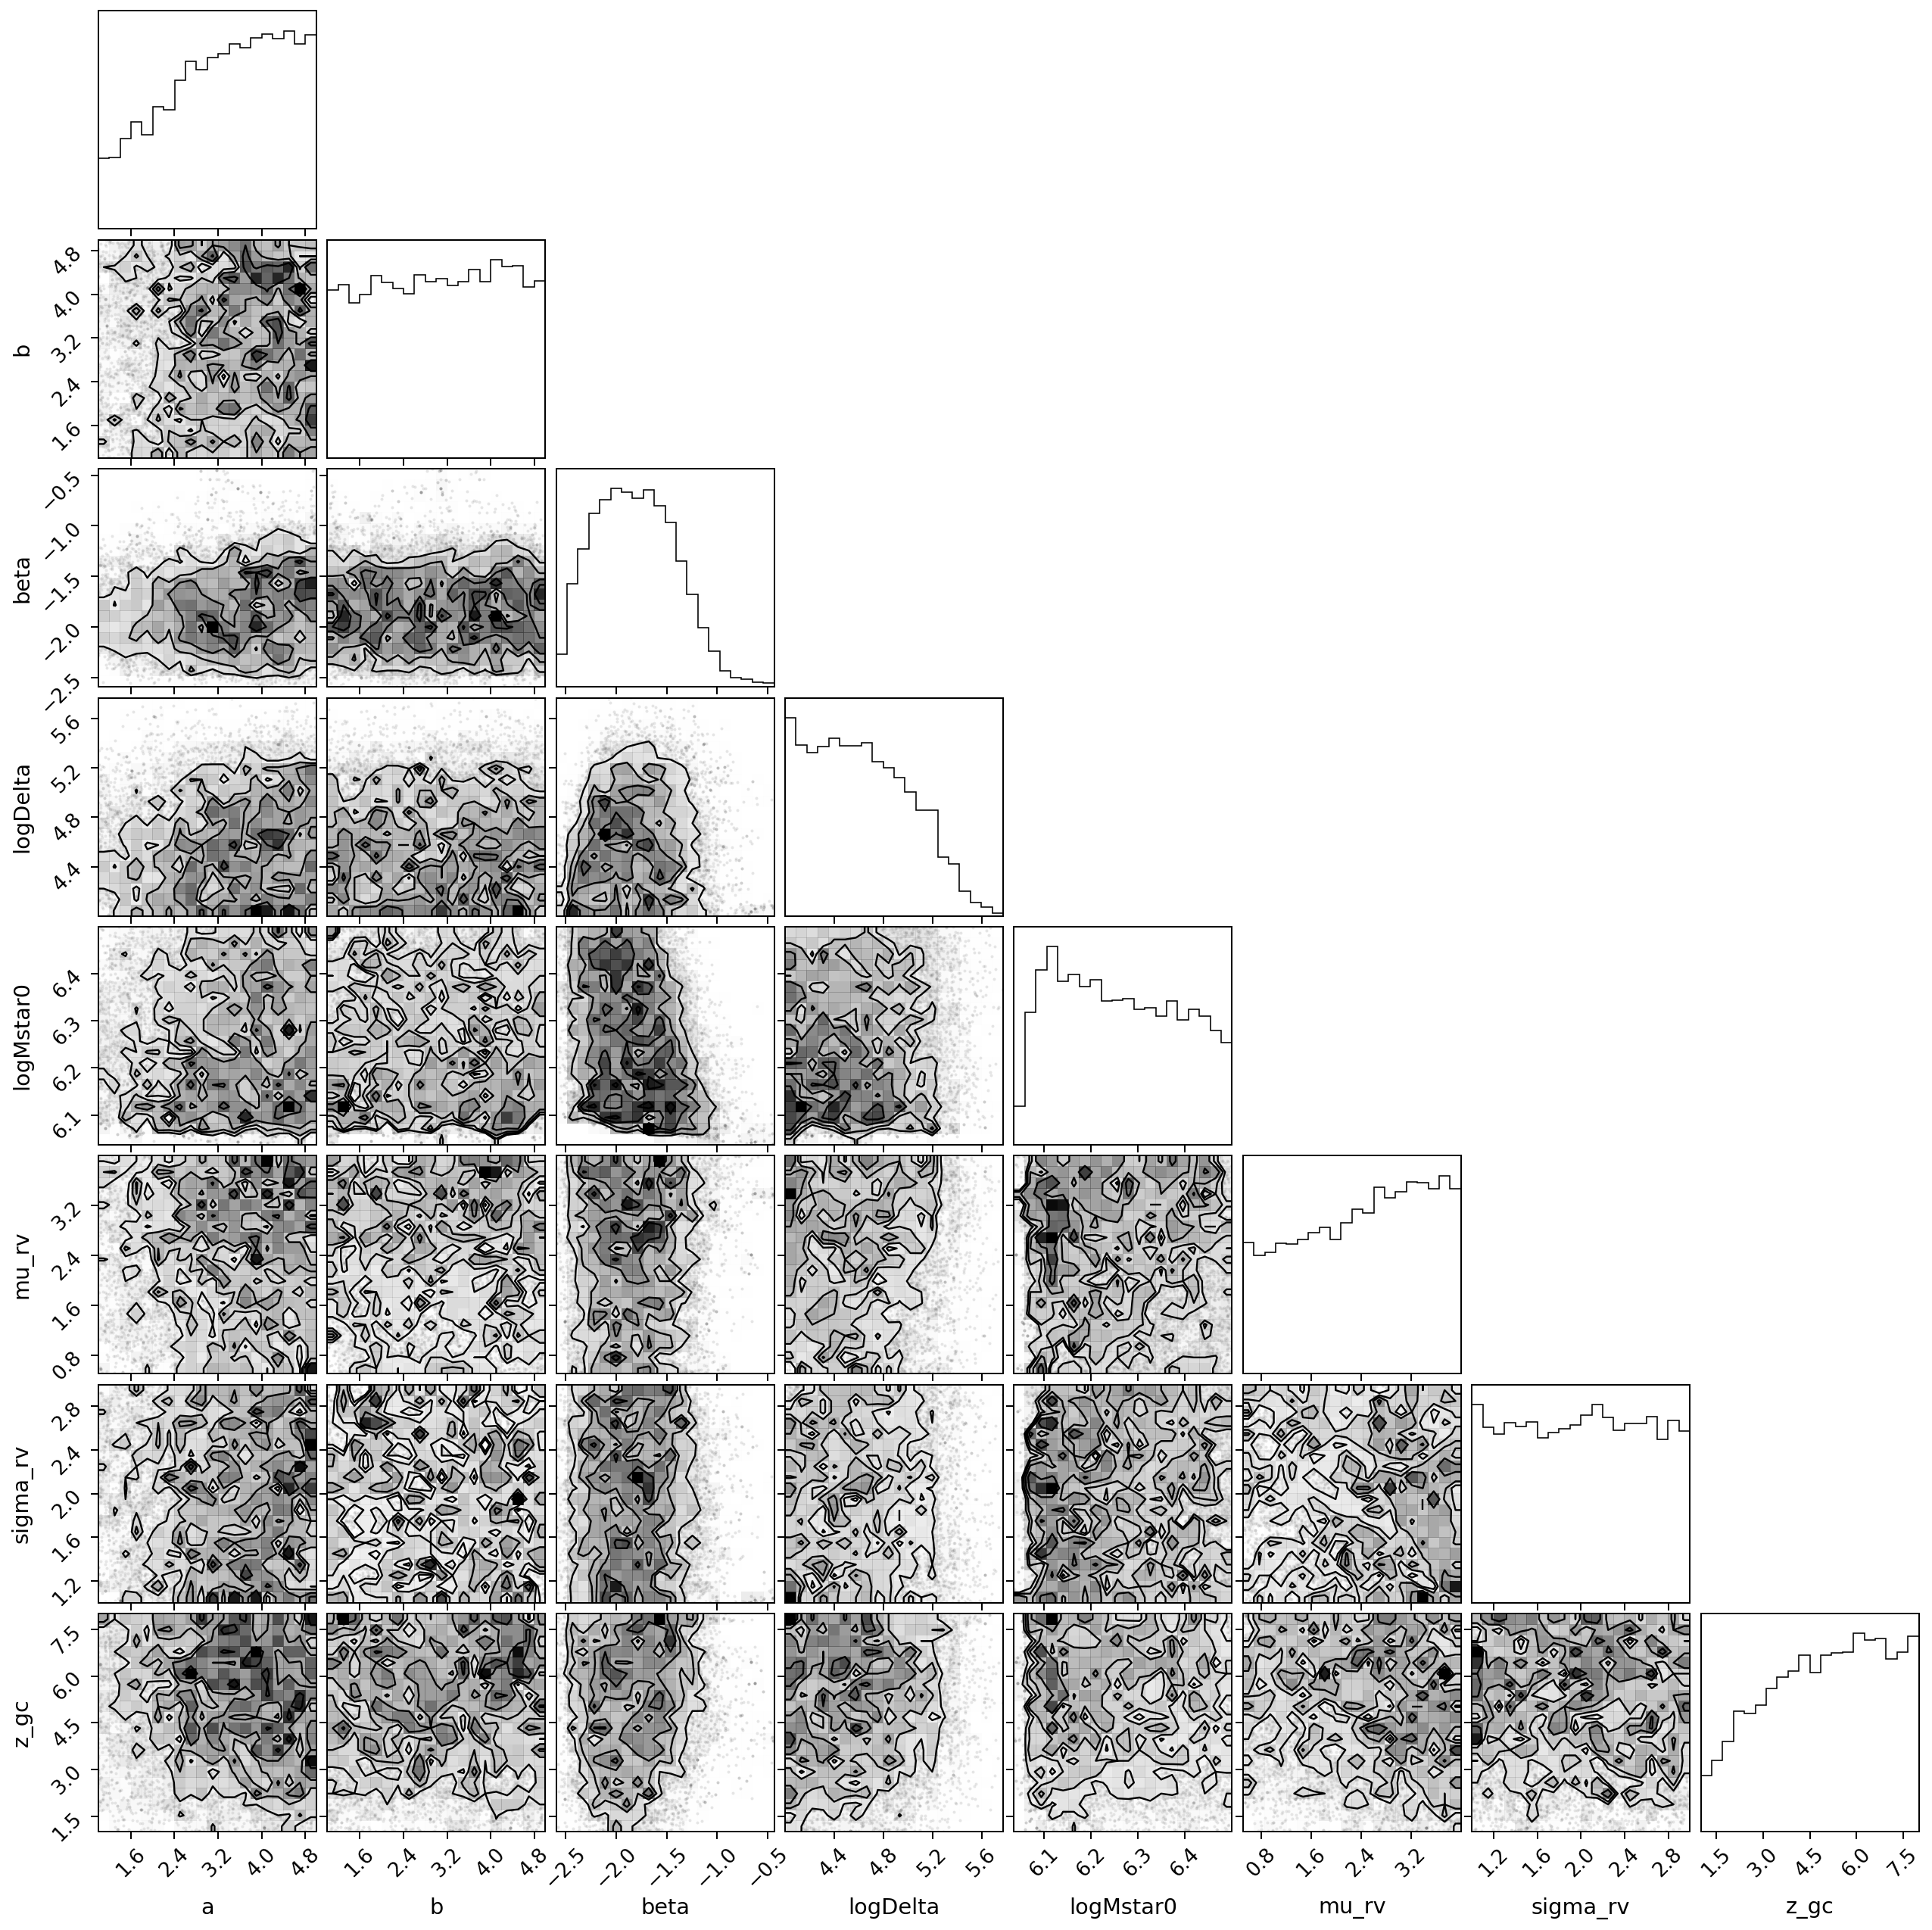

In [11]:
corner.corner(samples);